Name: Rishabh Chaturvedi

Roll No.: SM24MTECH11008



# TCP Congestion Control and Bufferbloat


In this assignment, you will create your own network simulation to investigate the dynamics of TCP and how seemingly minor configuration decisions made by network operators can have major performance effects.

As discussed in lecture, TCP is a protocol for obtaining reliable transmission over an unreliable packet-switched network. Another important component of TCP is congestion control, i.e. limiting end host send rates to prevent network infrastructure from getting overwhelmed with traffic.

However, networks can suffer congestion-related performance issues even when end hosts use TCP. One such issue, known as bufferbloat, can occur when packet buffers on routers and switches are too large.

In this assignment, you will use Mininet, a useful tool for network experiments, to emulate a small network and collect various performance statistics relevant to TCP congestion control and bufferbloat. This will allow you to reason about the effects of TCP and router configuration on network performance.   

**Put your name and netID in the cell below:**


**Name: Rishabh Chaturvedi**

**NetId: SM24MTECH11008**

## Background

#### TCP Congestion Window Size
The TCP congestion window size parameter, typically styled "cwnd," is maintained by the sender and determines how much traffic can be outstanding (sent but not acknowledged) at any time. There are many algorithms for controlling the value of cwnd during a TCP connection, all with the goal of maximizing the connection's throughput while preventing congestion. The additive increase and multiplicative decrease algorithm was discussed in lecture.

#### Bufferbloat
Bufferbloat is a phenomenon that happens when a switching device is configured to use excessively large buffers, which can in turn cause high latency and packet delay variation (jitter). This can happen even in a typical home network like the following:
<img width=600 src="figures/home-network.png">
Here, the end host in the home network is connected to the home router. The home router is then connected, via cable or DSL, to a headend router run by the Internet service provider (ISP). By simulating and experimenting with a similar network in Mininet, you will see how bufferbloat causes poor performance.

#### Mininet
Mininet is a network emulator with which you can create a custom network of virtual hosts, switches, controllers, and links, all on a single computer. The virtual devices in the emulated network can run real programs; anything that can run on linux can run on a Mininet device too. This makes Mininet a valuable tool for fast and easy simulation of network protcols and measurements. This [Introduction to Mininet](https://github.com/mininet/mininet/wiki/Introduction-to-Mininet) is a useful guide for getting started with Mininet's Python API.  The [Mininet website](http://www.mininet.org) has additional resources if you are interested.

## Part A: Network Simulation & Measurement
To start, you should first create the following network using Mininet's Python API, which emulates a typical home netowrk:
<img width=450 src="figures/mininet-topo.png">
Here h1 is a web server that has a fast connection (1Gb/s) to your home router. The home router has a slow downlink connection (1.5Mb/s) to your home computer. The round-trip propagation delay, or the minimum RTT between h1 and h2 is 20ms.  The router buffer (queue) size will be the parameterized independent variable in your simulation.

To create a custom topology in Mininet, we extend the mininet.topo.Topo class. We have already added the switch (the router) to topology for you. You need to add h1, h2, and links with appropriate characteristics to create the setting specified in the image above.  The first few subsections of the [Working with Mininet](https://github.com/mininet/mininet/wiki/Introduction-to-Mininet#working) section of the Mininet guide describe how to add elements to a topology and set performance parameters.

In [ ]:
from mininet.topo import Topo

class BBTopo(Topo):
    "Simple topology for bufferbloat experiment."

    def __init__(self, queue_size):
        super(BBTopo, self).__init__()

        # Create switch s0 (the router)
        s0 = self.addSwitch('s0')

        # TODO: Create two hosts with names 'h1' and 'h2'
        h1 = self.addHost('h1', ip='10.0.0.1')
        h2 = self.addHost('h2', ip='10.0.0.2')

        # TODO: Add links with appropriate bandwidth, delay, and queue size parameters.
        #       Set the router queue size using the queue_size argument
        #       Set bandwidths/latencies using the bandwidths and minimum RTT given in the network diagram above

        # Link between h1 and s0
        self.addLink(h1, s0, bw=1000, delay='10ms', max_queue_size=queue_size)

        # Link between s0 and h2
        self.addLink(s0, h2, bw=1.5, delay='50ms', max_queue_size=queue_size)


        return

Next, we need a couple of helper functions to generate traffic between the two hosts. The following function starts a long-lived TCP flow which sends data from h1 to h2 using **iperf**. [Iperf](https://iperf.fr/) is "a tool for active measurements of the maximum achievable bandwidth on IP networks."  You can think of this iperf traffic like a one-way video call. It continually attempts to send a high volume of traffic from the web server h1 to the home computer h2.

The following function receives one argument called `net`, which is an instance of mininet with a BBTopo topology that we have created above. We have written the part for the iperf server (h2). Notice that in iperf, server is the one that receives data, which should be the home computer h2. You need to complete the function to also start iperf on the iperf client (h1). The iperf session should run for the number of seconds given in the `experiment_time` argument.

You will need to use the `popen` function to run shell commands on a mininet host. The first argument to `popen` is a string command just like you would run in your shell. The second argument should be `shell=True`. You will need to look up the appropriate command line options to run iperf as a client for a given amount of time in the documentation here: [https://iperf.fr/iperf-doc.php#3doc](https://iperf.fr/iperf-doc.php#3doc). You will also need to include the IP address of h2 in your iperf command. This IP address can be accessed with the `h2.IP()` method.  

In [ ]:
def start_iperf(net, experiment_time):
    # Start a TCP server on host 'h2' using iperf.
    # The -s parameter specifies server mode
    # The -w 16m parameter ensures that the TCP flow is not receiver window limited (not necessary for client)
    print("Starting iperf server")
    h2 = net.get('h2')
    server = h2.popen("iperf -s -w 16m", shell=True)

    # Start a TCP client on host 'h1' using iperf.
    # Ensure that the client runs for experiment_time seconds
    print("Starting iperf client")
    h1 = net.get('h1')
    client = h1.popen("iperf -c {} -t {}".format(h2.IP(), experiment_time), shell=True)

    return server, client


Next, you need to complete the following function that starts a back-to-back ping train from h1 to h2 to measure RTTs. A ping should be sent every 0.1 seconds. Results should be redirected from stdout to the `outfile` argument.

As before, `net` is an instance of mininet with a BBTopo topology. As before, you will need to use `popen`.  The command argument to `popen` can redirect stdout using `>` just like a normal shell command.  Read the man page for `ping` for details on available command line arguments. Make sure the second argument to `popen` is `shell=True`.

In [ ]:
def start_ping(net, outfile="pings.txt"):
    # Start a ping train from h1 to h2 with 0.1 seconds between pings, redirecting stdout to outfile
    print("Starting ping train")
    h1 = net.get('h1')
    h2 = net.get('h2')
    ping_cmd = "ping -i 0.1 {} > {}".format(h2.IP(), outfile)
    h1.popen(ping_cmd, shell=True)

Next, we develop some helper functions to measure the congestion window of the TCP traffic. This will let us analyze at the dynamics of the TCP connections in the mininet network. The following functions are already complete.

In [ ]:
from subprocess import Popen
import os

# def start_tcpprobe(outfile="cwnd.txt"):
#     Popen("sudo cat /proc/net/tcpprobe > " + outfile, shell=True)
def start_tcpprobe(outfile="cwnd.txt"):
    print("Starting TCP probe. Output: {}".format(outfile))
    os.system("sudo rmmod tcp_probe; sudo modprobe tcp_probe")
    process = Popen("sudo cat /proc/net/tcpprobe > " + outfile, shell=True)
def stop_tcpprobe():
    Popen("killall -9 cat", shell=True).wait()

We then create a helper function that monitors the queue length on a given interface. This will let us analyze how the number of packets in router buffer queues affects performance. This function is already complete.

In [ ]:
from multiprocessing import Process
from monitor import monitor_qlen

def start_qmon(iface, interval_sec=0.1, outfile="q.txt"):
    monitor = Process(target=monitor_qlen,
                      args=(iface, interval_sec, outfile))
    monitor.start()
    return monitor

We also need a helper function that starts a webserver on h1. This function is already complete.

In [ ]:
from time import sleep

def start_webserver(net):
    h1 = net.get('h1')
    proc = h1.popen("python http/webserver.py", shell=True)
    sleep(1)
    return [proc]

Finally, we need a helper function that runs on h2, fetches the website from h1 every 3 seconds for `experiment_time`, and prints the average and standard deviation of the download times. This function is already complete

In [ ]:
from time import time
from numpy import mean, std
from time import sleep

def fetch_webserver(net, experiment_time):
    h2 = net.get('h2')
    h1 = net.get('h1')
    download_times = []

    start_time = time()
    while True:
        sleep(3)
        now = time()
        if now - start_time > experiment_time:
            break
        fetch = h2.popen("curl -o /dev/null -s -w %{time_total} ", h1.IP(), shell=True)
        download_time, _ = fetch.communicate()
        print "Download time: {0}, {1:.1f}s left...".format(download_time, experiment_time - (now-start_time))
        download_times.append(float(download_time))

    average_time = mean(download_times)
    std_time = std(download_times)
    print "\nDownload Times: {}s average, {}s stddev\n".format(average_time, std_time)

Now, we need to put together all the pieces to create the network, start all the traffic, and make the measurements.

The following `bufferbloat()` function should:
* create a `BBTopo` object
* start the TCP and queue monitors
* start a long-lived TCP flow using iperf
* start the ping train
* start the webserver
* Periodically download the index.html web page from h1 and measure how long it takes to fetch it

Note that the long lived flow, ping train, and webserver downloads should all be happening simultaneously. Once you have completed the assignment steps up until here, complete the sections marked `TODO` in the below `bufferbloat()` function. Each TODO section requires adding one line to call a function defined above.

In [ ]:
from mininet.node import CPULimitedHost, OVSController
from mininet.link import TCLink
from mininet.net import Mininet
from mininet.log import lg, info
from mininet.util import dumpNodeConnections

from time import time
import os
from subprocess import call

def bufferbloat(queue_size, experiment_time, experiment_name):
    # Don't forget to use the arguments!

    # Set the cwnd control algorithm to "reno" (half cwnd on 3 duplicate acks)
    #    Modern Linux uses CUBIC-TCP by default that doesn't have the usual sawtooth
    #    behaviour.  For those who are curious, replace reno with cubic
    #    see what happens...
    os.system("sysctl -w net.ipv4.tcp_congestion_control=reno")

    # create the topology and network
    topo = BBTopo(queue_size)
    net = Mininet(topo=topo, host=CPULimitedHost, link=TCLink,
                  controller= OVSController)
    net.start()

    # Print the network topology
    dumpNodeConnections(net.hosts)

    # Performs a basic all pairs ping test to ensure the network set up properly
    net.pingAll()

    # Start monitoring TCP cwnd size
    outfile = "{}_cwnd.txt".format(experiment_name)
    start_tcpprobe(outfile)

    # TODO: Start monitoring the queue sizes with the start_qmon() function.
    #       Fill in the iface argument with "s0-eth2" if the link from s0 to h2
    #       is added second in BBTopo or "s0-eth1" if the link from s0 to h2
    #       is added first in BBTopo. This is because we want to measure the
    #       number of packets in the outgoing queue from s0 to h2.
    outfile = "{}_qsize.txt".format(experiment_name)
    qmon = start_qmon(iface="TODO", outfile=outfile)

    # Start monitoring the queue sizes
    outfile = "{}_qsize.txt".format(experiment_name)
    qmon = start_qmon(iface="s0-eth2", outfile=outfile)  # Interface set to "s0-eth2" as link to h2 is added second


    # TODO: Start the long lived TCP connections with the start_iperf() function
    start_iperf(net, experiment_time)


    # TODO: Start pings with the start_ping() function
    outfile = "{}_pings.txt".format(experiment_name)
    start_ping(net, outfile)


    # TODO: Start the webserver with the start_webserver() function
    start_webserver(net)

    # TODO: Measure and print website download times with the fetch_webserver() function
    fetch_webserver(net, experiment_time)

    # Stop probing
    stop_tcpprobe()
    qmon.terminate()
    net.stop()

    # Ensure that all processes you create within Mininet are killed.
    Popen("pgrep -f webserver.py | xargs kill -9", shell=True).wait()
    call(["mn", "-c"])

Once you have completed all the steps above, use the `bufferbloat()` function to run the experiment twice, once with queue size of a 20 packets and then queue size of 100 packets. Make sure to run the experiments long enough to see the dynamics of TCP, like the sawtooth behavior of cwnd, in your results (300 seconds should be good).  Choose `experiment_name` arguments that reflect the queue size

In [ ]:
from subprocess import call
call(["mn", "-c"])

# TODO: call the bufferbloat function twice, once with queue size of 20 packets and once with a queue size of 100.

# Run bufferbloat experiment with a queue size of 20 packets for 300 seconds
bufferbloat(queue_size=20, experiment_time=300, experiment_name="bufferbloat_20_packets")

# Run bufferbloat experiment with a queue size of 100 packets for 300 seconds
bufferbloat(queue_size=100, experiment_time=300, experiment_name="bufferbloat_100_packets")

h1 h1-eth0:s0-eth1
h2 h2-eth0:s0-eth2
*** Ping: testing ping reachability
h1 -> h2 
h2 -> h1 
*** Results: 0% dropped (2/2 received)


Starting TCP probe. Output: bufferbloat_20_packets_cwnd.txt
Starting iperf server
Starting iperf client
Starting ping train
Download time: 0.465, 297.0s left...
Download time: 1.482, 293.5s left...
Download time: 1.853, 289.0s left...
Download time: 0.574, 284.1s left...
Download time: 1.728, 280.5s left...
Download time: 0.550, 275.8s left...
Download time: 1.569, 272.2s left...
Download time: 0.544, 267.6s left...
Download time: 1.886, 264.0s left...
Download time: 1.826, 259.1s left...
Download time: 1.425, 254.3s left...
Download time: 2.440, 249.8s left...
Download time: 0.538, 244.4s left...
Download time: 1.616, 240.8s left...
Download time: 0.541, 236.2s left...
Download time: 1.880, 232.6s left...
Download time: 3.668, 227.7s left...
Download time: 1.507, 221.0s left...
Download time: 0.522, 216.5s left...
Download time: 1.887, 212.9s left...
Download time: 4.051, 208.0s left...
Download time: 1.501, 200.9s left...
Download time: 2.132, 196.4s left...
Download time: 0.568, 191

h1 h1-eth0:s0-eth1
h2 h2-eth0:s0-eth2
*** Ping: testing ping reachability
h1 -> h2 
h2 -> h1 
*** Results: 0% dropped (2/2 received)


Starting TCP probe. Output: bufferbloat_100_packets_cwnd.txt
Starting iperf server
Starting iperf client
Starting ping train
Download time: 4.715, 297.0s left...
Download time: 1.658, 289.2s left...
Download time: 0.912, 284.6s left...
Download time: 0.988, 280.6s left...
Download time: 1.034, 276.6s left...
Download time: 1.133, 272.6s left...
Download time: 1.181, 268.4s left...
Download time: 1.230, 264.2s left...
Download time: 1.287, 259.9s left...
Download time: 1.351, 255.6s left...
Download time: 1.398, 251.3s left...
Download time: 1.449, 246.8s left...
Download time: 1.520, 242.4s left...
Download time: 1.556, 237.8s left...
Download time: 1.609, 233.3s left...
Download time: 1.641, 228.6s left...
Download time: 1.701, 223.9s left...
Download time: 1.732, 219.2s left...
Download time: 1.800, 214.5s left...
Download time: 1.832, 209.6s left...
Download time: 1.874, 204.8s left...
Download time: 1.914, 199.9s left...
Download time: 1.975, 194.9s left...
Download time: 2.021, 18

## Part B: Plotting Results

In this part of the assignment, you will analyze your measurements by plotting the variations in congestion window, queue length, and ping RTT versus time. We have provided plotting functions for each of these measurements, which are called in the following already complete `plot_measurements()` function.


In [ ]:
%matplotlib inline
from plot_cwnd import plot_congestion_window
from plot_qsize import plot_queue_length
from plot_ping import plot_ping_rtt

def plot_measurements(experiment_name_list, cwnd_histogram=False):

    # plot the congestion window over time
    for name in experiment_name_list:
        cwnd_file = "{}_cwnd.txt".format(name)
        plot_congestion_window(cwnd_file, histogram=cwnd_histogram)

    # plot the queue size over time
    for name in experiment_name_list:
        qsize_file = "{}_qsize.txt".format(name)
        plot_queue_length(qsize_file)

    # plot the ping RTT over time
    for name in experiment_name_list:
        ping_file = "{}_pings.txt".format(name)
        plot_ping_rtt(ping_file)

Now you need to call the `plot_measurements` function such that the `experiment_name_list` argument is list of the `experiment_name` arguments you used to run `bufferbloat()` above.  This should generate 6 plots with the results of the experiments.

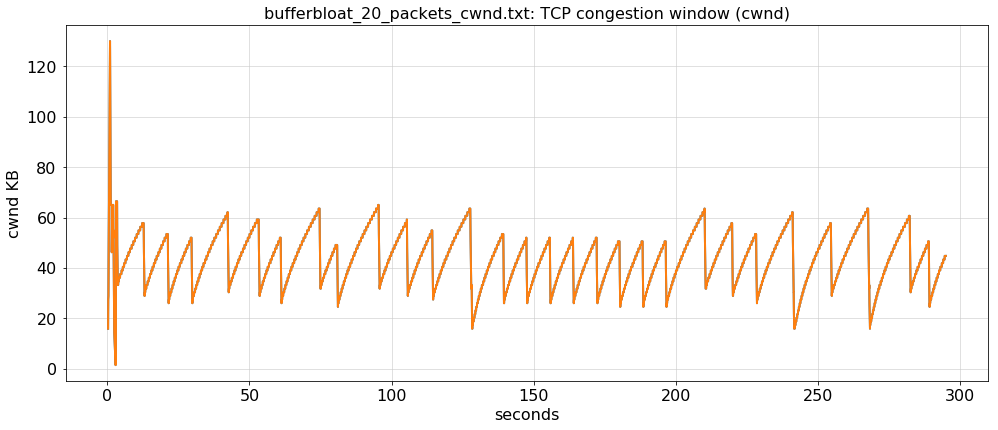

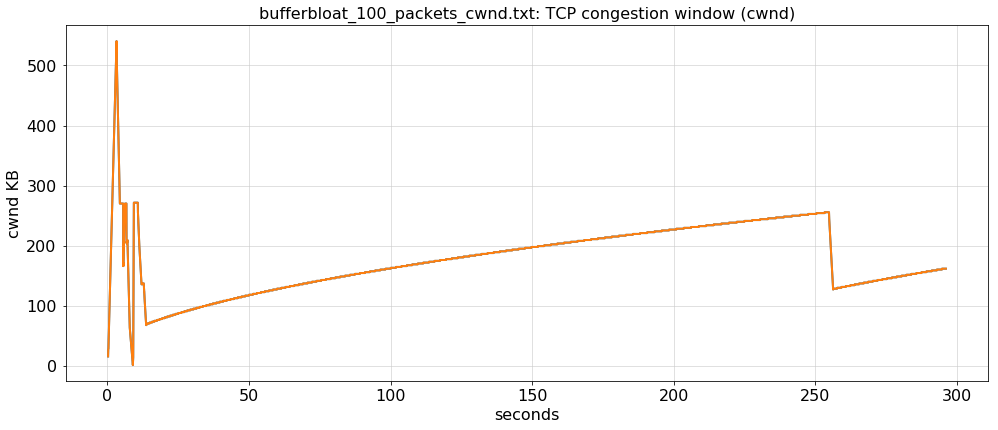

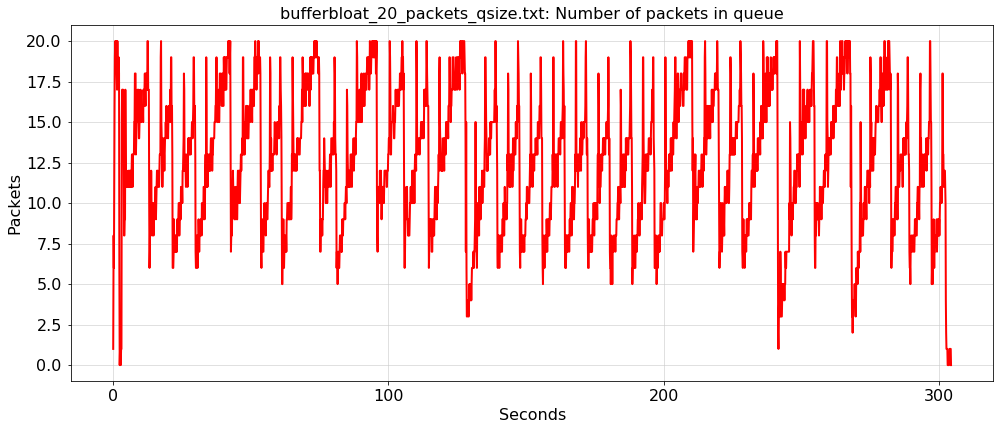

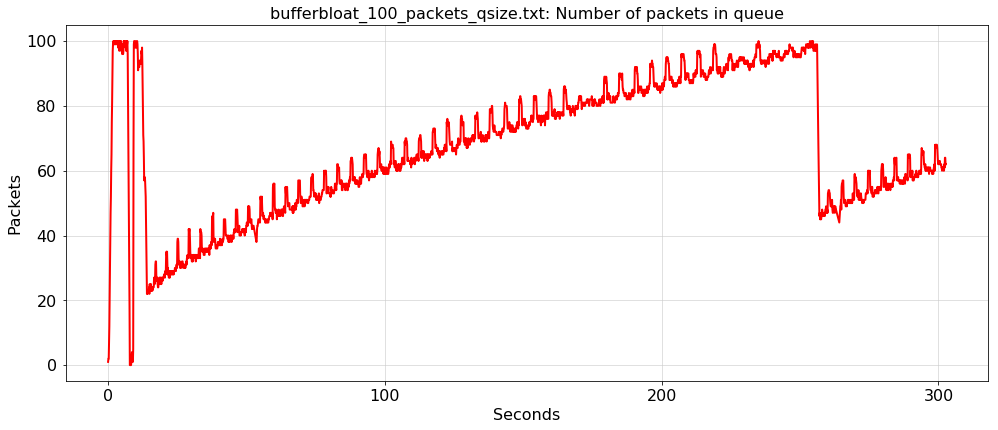

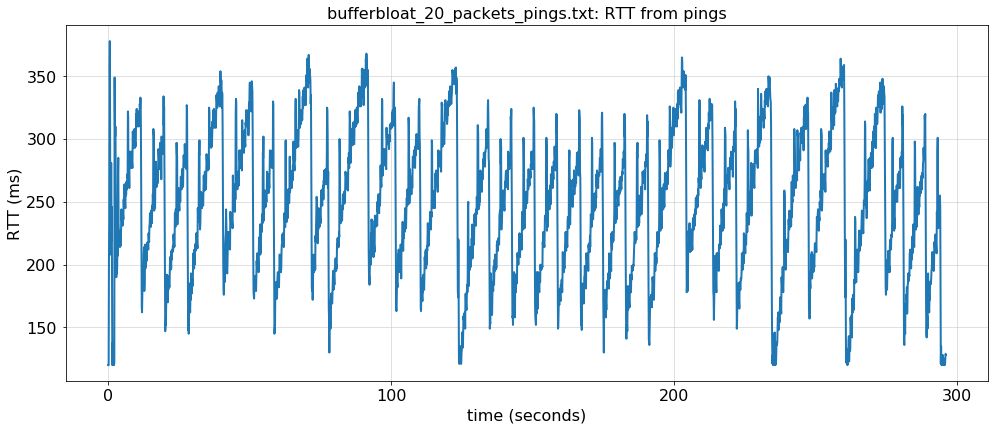

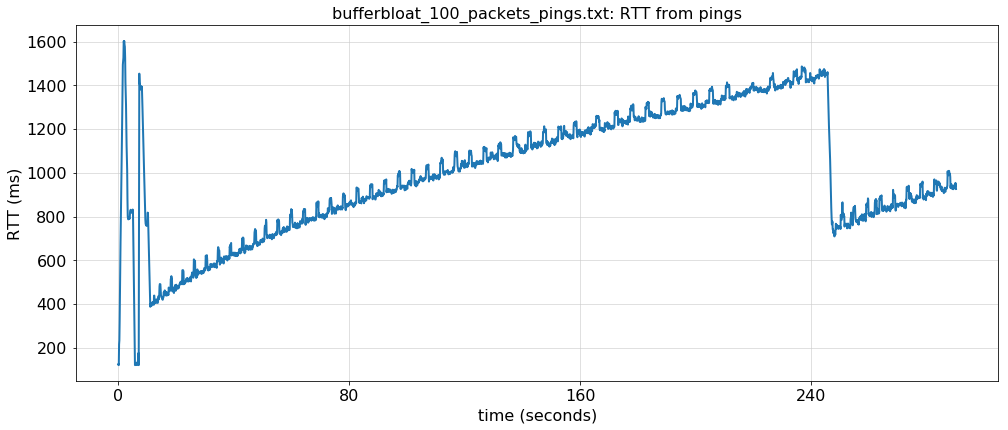

In [ ]:
#TODO: Call plot_measurements() to plot your results

# List of experiment names
experiment_name_list = ["bufferbloat_20_packets", "bufferbloat_100_packets"]

# Call the plot_measurements function to plot the results
plot_measurements(experiment_name_list, cwnd_histogram=False)


## Part C: Analysis

In this part of the assignment, you will answer some questions about TCP and bufferbloat using your simulations and the plots from the previous section.  This questions are intentionally open-ended and many have multiple correct answers.  There is no required answer length, but attempt to be both thorough and concise.  1-2 sentences is probably too short. More than 2-3 paragraphs is probably too long.

Take some time first to think about the simulation you just performed. The simulation was set up like a home network with a home computer connected to a remote server through a router. The link from the router to the server had much lower bandwidth than the link from the home computer to the router. The independent variable in the simulation was the maximum length of the buffer of packets waiting to be sent from the router to the server.

There were 3 sources of traffic:
1. A long-lasting TCP session (creating using iperf) sending a high volume of traffic from the home computer to the server.
2. Regularly spaced pings and ping replies to and from the home computer and the server
3. Regularly spaced attempts to download a website (using HTTP over TCP) from the home computer to the server.

As you (hopefully) discovered through the experiment, increasing the length of the packet buffer on the router significantly reduced performance by both ping RTT and HTTP download rate metrics.

### Questions

#### Q1.
What computer networks other than a home network might have a configuration like the one you simulated?

#### A1.
Several other types of computer networks exhibit similar configurations are:

i.) **Public Wi-Fi Networks** :

- Places like cafes or airports have many users sharing a slow internet link.
-Too much traffic at once can make everything slower.<br/>

ii.) **Mobile Networks - LTE/5G** :

- Phones connect to cell towers that have slower links to the main network.
- Heavy use can cause delays, especially for things like video calls.<br/>

iii.) **IoT Networks** :

- Smart devices send data through a gateway to the internet.
- Delays in the gateway can cause problems for time-sensitive tasks.

iv.) **Branch Office Networks** :

- Smaller offices connect to headquarters using slower links.
- Uploads or downloads can slow down real-time work like video calls.

#### Q2.
Write a symbolic equation to describe the relation between RTT and queue size.

The symbolic equation should be generalized to any queue size. Basically, consider a snapshot of a system at one point of time, and use queue size and link delays parametrically to compute the RTT

An example (incorrect) symbolic equation:
$$RTT = kq^2$$
where $k$ is a constant factor and $q$ is the number of packets in the queue. Your equation is not limited to $k$ and $q$.

#### A2.
The symbolic equation representing the relationship between RTT and queue size (Q) can be expressed as:

$$ RTT = 2 \times D + \frac {Q}{B}$$

Here ,
- $Q $ is the queue size (number of packets in the queue)
- $D $ is the one way propagation delay for the packet to travel over the link
- $B$ is called bandwith (transmission capacity of the link)

#### Q3.  
Describe in technical terms why increasing buffer size reduces performance (RTTs and webpage download times), causing the bufferbloat effect.  Be sure to explicitly reference the plots you generated and the relationship between TCP congestion control and buffer size. *This is the most important question and will be weighted correspondingly more.*

### A3

#### 1. Impact of Buffer Size on Queuing Delay

**Queue Size Observations:**
- **20-packet buffer**: The queue size exhibits minor fluctuations with occasional spikes (refer to Plot 3).  
- **100-packet buffer**: The queue steadily fills up, approaching the buffer's maximum capacity, resulting in consistently higher delays (refer to Plot 4).  

**Analysis:**
- Larger buffers allow more packets to queue. Transmission time is proportional to the queue size \(q\) and inversely related to the link bandwidth \(B\), meaning as \(q\) grows, so does the queuing delay (q/B).  
- This directly impacts the Round-Trip Time (RTT), which comprises propagation delay and queuing delay:  
  - **RTT Behavior**:  
    - For a 20-packet buffer, RTT fluctuates within a lower range (200–400 ms, Plot 5).  
    - For a 100-packet buffer, RTT rises sharply, exceeding 1400 ms (Plot 6).  
<br/>

---
<br/>

#### 2. TCP Congestion Control with Larger Buffers

**Congestion Window (CWND) Observations:**
- **20-packet buffer**: The CWND oscillates regularly, reflecting effective TCP congestion control (refer to Plot 1).  
- **100-packet buffer**: CWND steadily increases, showing delayed feedback on network congestion (refer to Plot 2).  

**Analysis:**
- TCP adjusts the sending rate based on ACK feedback:  
  - **Small Buffer (20 packets)**: Congestion is promptly detected through packet drops (via duplicate ACKs or timeouts). TCP reduces CWND, aligning it with network capacity.  
  - **Large Buffer (100 packets)**: Fewer packet drops occur, but delayed ACKs due to queuing lead TCP to misinterpret the network's capacity, causing CWND to grow excessively. This amplifies queuing delays and RTT.  
<br/>

---

<br/>

#### 3. Effects on RTT and Webpage Download Times

**RTT Observations:**
- **20-packet buffer**: RTT stays below 400 ms with minimal fluctuations (Plot 5).  
- **100-packet buffer**: RTT steadily increases over time, reaching around 1400 ms (Plot 6).  

**Analysis:**
- Greater queuing delay inflates RTT, which consists of propagation, transmission, and queuing delays.  
- Elevated RTT significantly degrades latency-sensitive tasks like webpage downloads due to delayed acknowledgments and retransmissions, slowing overall data transfer.  
<br/>

---

<br/>

#### 4. Bufferbloat Feedback Loop

**How Bufferbloat Escalates:**

- A larger CWND injects more traffic, further filling the buffer and worsening delays.  
- This self-reinforcing cycle negatively impacts performance across all network traffic.  
- Excessive packet accumulation in the buffer increases queuing delay, which inflates RTT.  
- Higher RTT delays ACKs, leading TCP to overestimate network capacity, causing CWND to expand.

#### Q4.
Re-describe the cause of the bufferbloat effect using a non-technical analogy to something other than computer networking.  It is important to be able to describe technical content such that a layperson can understand, and generating analogies often helps your own reasoning.

#### A4.
Bufferbloat happens when there’s too much room for data to wait in line, leading to unnecessary delays even though the system can process data efficiently. It’s like a toll booth on a highway with a parking lot for waiting cars. If the lot holds only 30 cars, the line stays short, and traffic flows smoothly. But if the lot can hold 150 cars, the line becomes much longer. Even though the toll booth works at the same speed, the long line causes delays. The issue is not the speed of the toll booth but the oversized parking lot creating congestion.

In networks, large buffers work similarly: they basically allow more data to queue up, increasing delays and round-trip times despite of efficient data processing. Smaller buffers, like smaller parking lots, help reduce delays and improve flow. The key is finding a balance—buffers that are too small may not hold enough data, but overly large buffers cause unnecessary delays.

#### Q5.
Is the bufferbloat effect specific to the type of network, traffic, and/or TCP congestion control algorithm we simulated, or is it a general phenomenon?

Are there any times when increasing router buffer size would improve performance? If so, give an example.  If not, explain why not.

#### A5.
Bufferbloat is a widespread issue that occurs when network buffers, often in routers or switches become excessively large. This results in increased latency and jitter. Hence, negatively impacting performance.

It is not limited to any specific type of network traffic or TCP congestion control algorithm but arises when large buffers delay packet delivery, especially during high traffic loads. This phenomenon can affect various network types, including both wired and wireless systems.

While increasing router buffer size can enhance performance in some cases, it often involves trade-offs. Buffers that are too small may lead to packet drops, triggering retransmissions and reducing overall throughput.

Example of When Larger Buffers Can Improve Performance:
In high-bandwidth, low-latency networks, such as underutilized fiber-optic connections, increasing buffer size can prevent packet loss. This is particularly beneficial for TCP-based applications requiring reliable delivery without retransmissions.

#### Q6.
Identify and describe a way to mitigate the bufferbloat problem without reducing buffer sizes.  

#### A6.

### Mitigating Bufferbloat with AQM Techniques:

1. **Controlled Delay (CoDel)**:
   - Keeps queue delay constant by dropping/marking long-waiting packets.
   - Prevents excessive buffering and reduces latency.

2. **Random Early Detection (RED)**:
   - Drops packets randomly based on average queue size before the buffer fills.
   - Signals senders to reduce rates, avoiding congestion and latency spikes.

3. **Fair Queuing CoDel (FQ-CoDel)**:
   - Combines fair queuing and CoDel principles to manage traffic flows equitably.
   - Drops packets from congested flows and ensures fair buffer usage among flows.

### Benefits:
- Manages large buffers effectively.
- Reduces latency and congestion.
- Maintains fairness across traffic flows.


## Submission





**ANTI-PLAGIARISM Statement**


I certify that this assignment/report is the result of my own independent work, based on my personal study and research. All sources, including books, articles, software, datasets, reports, and communications, have been properly acknowledged. This work has not been previously submitted for assessment in any other course unless specific permission was granted by the respective instructors. I also acknowledge the use of AI tools, such as LLMs (e.g., ChatGPT), for assistance in refining this assignment, if used. I have ensured that their usage complies with the academic integrity policies of this course. I pledge to uphold the principles of honesty, integrity, and responsibility at CSE@IITH, and understand my duty to report any violations of academic integrity by others if I become aware of them.

<br/>

Name: Rishabh Chaturvedi

Roll No: SM24MTECH11008

Date: 17 Nov 2024

Signature: Rishabh